## Import

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor



## Data preparation

In [18]:
clean_df = pd.read_csv('../data/processed/video_data_processed.csv')

In [19]:
clean_df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year
24635,_lPtapNICHs,BEPEC by Kanth - #BuildExperience & Get Hired!,Full Stack Developer Job-Ready Roadmap 🔥 #soft...,You + Right Roadmap + Right Projects = Unstopp...,full stack web development|full stack web deve...,2023-05-25 14:12:40+00:00,18200,1351,15,57,hd,False,14,25,3,5,2023
20174,xX_qCIhQNuA,Snowflake Inc.,Joyce Avila What a SnowPro Certification can...,Learn the value of Snowflake's SnowPro Certifi...,snowflake|redshift|aws|data|warehousing|date|w...,2020-07-25 15:08:23+00:00,1797,17,1,1642,hd,False,15,25,5,7,2020
59131,gCkleG-r2eI,The NLP Lab,A Neural Corpus Indexer for Document Retrieval...,Link: https://openreview.net/forum?id=fSfcEYQP...,(notag),2022-12-15 07:00:11+00:00,468,11,0,365,hd,False,7,15,3,12,2022
31804,KFvb_mluq8Y,george hotz archive,George Hotz | Programming | coronavirus stream...,Date of stream 25 Mar 2020.\nLive-stream chat ...,programming|livecoding|georgehotz|self|driving...,2020-03-26 16:19:27+00:00,53532,565,189,15259,hd,True,16,26,3,3,2020
18321,JGv-98I_Mb4,DataCamp,#116 Value Creation Within the Modern Data Sta...,With the increasing rate at which new data too...,data science|podcast|data scientist|data|analy...,2022-12-06 10:00:04+00:00,407,4,1,2907,hd,False,10,6,1,12,2022


## Feature engineering

In [20]:
X = clean_df[['viewCount','likeCount', 'commentCount', 'hour', 'day', 'month', 'year']]
# Tạo cột nhãn, ví dụ: nếu viewCount lớn hơn một ngưỡng nào đó, coi video đó là phổ biến
threshold_viewCount = clean_df['viewCount'].quantile(0.7)
clean_df['isTrending'] = (clean_df['viewCount'] > threshold_viewCount).astype(int)
y = clean_df['isTrending']

In [21]:
clean_df.sample(5)


,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year,isTrending
38701,gVfoXPipTig,"Arpan Gupta Data Scientist, IITian",Linear vs Logistic Regression,In this video I will explain you the differenc...,Machine learning|data science|linear regressio...,2019-03-14 19:10:33+00:00,6918,85,5,248,hd,False,19,14,3,3,2019,0
12619,9JZID-h6ZJ0,CodeEmporium,Bellman Equation - Explained!,Let's talk about the most consequential equati...,Machine Learning|Deep Learning|Data Science|Ar...,2023-10-23 14:00:08+00:00,1401,60,7,545,hd,False,14,23,0,10,2023,0
22670,nG1ClR-ldeI,Bhavesh Bhatt,LangChain Crash Course : Learn LangChain in 20...,Welcome to the LangChain Crash Course! In this...,Bhavesh Bhatt|Data Scientist|Machine Learning|...,2023-06-12 12:45:05+00:00,1392,56,10,1182,hd,False,12,12,0,6,2023,0
53209,r94kI6my0QQ,The Coding Train,3.3 Mapping Database Entries with Leaflet.js -...,💻https://github.com/CodingTrain/Intro-to-Data-...,weather here|weather app|leaflet|leaflet.js|Ja...,2019-06-14 13:38:07+00:00,64811,1038,41,827,hd,True,13,14,4,6,2019,1
53790,_cDPN2Ief6Q,The Coding Train,Live Stream #58: Networking Agar.io and the Hi...,This Live Stream is about two main subjects: T...,p5|js|coding|rainbow|live|agar|io|processing|p...,2016-09-02 18:51:27+00:00,6448,109,7,8124,hd,False,18,2,4,9,2016,0


## Training model

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y ,test_size=0.2)
model = LogisticRegression(solver = 'liblinear',max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Evaluation

In [23]:
model.score(X_valid,y_valid)

0.9997501457483134

## Prediction

In [24]:
y_pred = model.predict(X_valid)

In [25]:
precision_score(y_valid,y_pred), recall_score(y_valid,y_pred)

(0.9994370954123276, 0.9997184684684685)

In [26]:
print(classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8455
           1       1.00      1.00      1.00      3552

    accuracy                           1.00     12007
   macro avg       1.00      1.00      1.00     12007
weighted avg       1.00      1.00      1.00     12007



##### Decision Tree

In [27]:
decision_Tree = DecisionTreeRegressor()
decision_Tree.fit(X_train,y_train)


DecisionTreeRegressor()

In [28]:
decision_Tree.score(X_valid,y_valid)

1.0

# TEMP


In [29]:
from sklearn.svm import LinearSVC , SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
# !pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

seed = 2023
models = [
    LinearSVC(random_state= seed),
    SVC(random_state= seed),
    KNeighborsClassifier(metric ='minkowski',p=2),
    DecisionTreeClassifier(random_state= seed),
    RandomForestClassifier(random_state= seed),
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(use_label_encoder = False, eval_metric ='logloss',random_state= seed)
]

/Users/home/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/home/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/home/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/home/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/home/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'aut

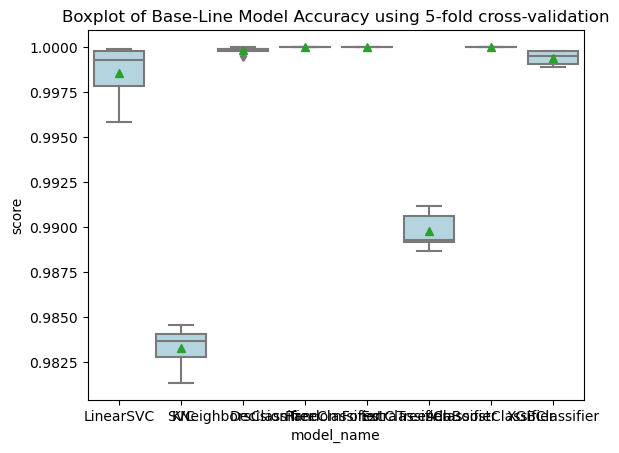

,Mean,Standard Deviation
model_name,,
AdaBoostClassifier,1.000000,0.000000
DecisionTreeClassifier,1.000000,0.000000
RandomForestClassifier,1.000000,0.000000
KNeighborsClassifier,0.999813,0.000200
XGBClassifier,0.999396,0.000425
LinearSVC,0.998522,0.001716
ExtraTreesClassifier,0.989776,0.001060
SVC,0.983300,0.001261


In [30]:
def generate_baseline_result(models, X, y, metrics, cv=5, plot_result=False):
    # define k-fold
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=seed)
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        scores = cross_val_score(model, X, y, scoring=metrics, cv=kfold)
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))

    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'score'])
    
    mean = cv_df.groupby('model_name')['score'].mean()
    std = cv_df.groupby('model_name')['score'].std()
    
    baseline_results = pd.concat([mean,std],axis =1, ignore_index=True)
    baseline_results.columns =['Mean','Standard Deviation']
    baseline_results.sort_values(by=['Mean'], ascending = False, inplace = True)
    
    if plot_result:
        sns.boxplot(x ='model_name',y = 'score', data = cv_df, color ='lightblue',showmeans=True)
        plt.title('Boxplot of Base-Line Model Accuracy using 5-fold cross-validation')
        plt.show()
    
    return baseline_results

# Metric: https://scikit-learn.org/stable/modules/model_evaluation.html
generate_baseline_result(models, X_train, y_train, metrics='accuracy',cv=5,plot_result =True )